In [2]:
import sys


import mlflow
from seisbench_training.utils.model_utils import SeisBenchLit
import pandas as pd
import seisbench.models as sbm
import seisbench.data as sbd
import seisbench.generate as sbg
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pathlib import Path
import torch

from sklearn.metrics import (
    precision_recall_curve,
    precision_recall_fscore_support,
    roc_curve,
    matthews_corrcoef,
    mean_absolute_error,
)


/home/khuzaima/miniforge3/envs/seisbench/lib/python3.13/site-packages/seisbench/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
def get_eval_augmentations():
    return [
        sbg.SteeredWindow(windowlen=3001, strategy="pad"),
        sbg.ChangeDtype(np.float32),
        sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    ]


In [4]:
def load_best_model_mlflow(experiment_name: str, best_model_path: str) -> SeisBenchLit:
    # Get the experiment by name
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        raise ValueError(f"Experiment '{experiment_name}' not found.")

    # Search for runs in the experiment
    runs: pd.DataFrame = mlflow.search_runs(experiment.experiment_id)
    if runs.empty:
        raise ValueError(f"No runs found for experiment '{experiment_name}'.")

    runs_df_filtered = runs[runs["status"] == "FINISHED"][
        [
            col
            for col in runs.columns
            if col.startswith("params.") or col.startswith("metrics.")
        ]
    ].dropna()

    runs_df_indices = runs_df_filtered.sort_values(
        "metrics.val_loss",
        ascending=False,
    ).index
    runs_df = runs.loc[runs_df_indices, :]

    best_run_id = runs_df["run_id"].tolist()[0]
    best_run_df = runs_df[runs_df["run_id"] == best_run_id]

    artifact_dir = best_run_df["artifact_uri"].iloc[0]

    return SeisBenchLit.load_from_checkpoint(artifact_dir + best_model_path)


In [5]:
model = load_best_model_mlflow(
    "full_training_100_epochs_2.0",
    "/best_model_gaussian/best_model_gaussian.ckpt",
)
labels = pd.read_csv("output/generated_labels.csv")
dataset = sbd.bohemia.BohemiaSaxony(
    sampling_rate=100, cache="full", component_order="ZNE"
)

In [6]:
def predict(set_name: list, dataset: sbd.BenchmarkDataset) -> pd.DataFrame:
    for set in set_name:
        split = dataset.get_split(set)
        if split is None:
            raise ValueError(f"Dataset does not have a split named '{set}'.")
        split.preload_waveforms(pbar=True)
        labels_subset = labels[
            labels["trace_split"] == set
        ].copy()  # avoid modifying original df
        generator = sbg.SteeredGenerator(split, labels_subset)
        generator.add_augmentations(get_eval_augmentations())

        loader = torch.utils.data.DataLoader(
            generator,
            batch_size=1024,
            shuffle=False,
            num_workers=16,
        )
        trainer = pl.Trainer()

        predictions = trainer.predict(model, loader)
        merged_predictions = []
        for i, _ in enumerate(predictions[0]):
            merged_predictions.append(torch.cat([x[i] for x in predictions]))

        merged_predictions = [x.cpu().numpy() for x in merged_predictions]
        labels_subset["score_detection"] = merged_predictions[0]
        labels_subset["score_p_or_s"] = merged_predictions[1]
        labels_subset["p_sample_pred"] = (
            merged_predictions[2] + labels_subset["start_sample"]
        )
        labels_subset["s_sample_pred"] = (
            merged_predictions[3] + labels_subset["start_sample"]
        )

    return labels_subset

In [7]:
set_name = ["test"]
results = predict(set_name, dataset)

Preloading waveforms: 100%|██████████| 23718/23718 [00:09<00:00, 2420.85it/s]
/home/khuzaima/miniforge3/envs/seisbench/lib/python3.13/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/khuzaima/miniforge3/envs/seisbench/lib/python3 ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [8]:
results["phase_label_bin"] = results["phase_label"] == "P"
results["phase_label_bin"]

7         True
8        False
9         True
10       False
40        True
         ...  
84004    False
84005     True
84006    False
84007     True
84008    False
Name: phase_label_bin, Length: 41696, dtype: bool

In [9]:
prec, recall, thr = precision_recall_curve(
    results["phase_label_bin"], results["score_p_or_s"]
)

In [10]:
f1 = 2 * prec * recall / (prec + recall)
opt_index = np.nanargmax(f1)
opt_thr = thr[opt_index]
mcc_thrs = np.sort(results["score_p_or_s"].values)
mcc_thrs = mcc_thrs[np.linspace(0, len(mcc_thrs) - 1, 50, dtype=int)]
mccs = []
for thr in mcc_thrs:
    mccs.append(
        matthews_corrcoef(results["phase_label_bin"], results["score_p_or_s"] > thr)
    )
mcc = np.max(mccs)
mcc_thr = mcc_thrs[np.argmax(mccs)]

In [11]:
test_stats = {
    "test_phase_precision": prec[opt_index],
    "test_phase_recall": recall[opt_index],
    "test_phase_f1": f1[opt_index],
    "phase_threshold": opt_thr,
    "dev_phase_mcc": mcc,
    "phase_threshold_mcc": mcc_thr,
}

test_stats

{'test_phase_precision': np.float64(0.9564533053515215),
 'test_phase_recall': np.float64(0.9532524576448441),
 'test_phase_f1': np.float64(0.9548501990362456),
 'phase_threshold': np.float32(0.9428109),
 'dev_phase_mcc': np.float64(0.91643815437411),
 'phase_threshold_mcc': np.float32(0.9999939)}

In [1]:
fpr, tpr, _ = roc_curve(results["phase_label_bin"], results["score_p_or_s"])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(fpr, tpr)
ax.set_aspect("equal")

ax.set_xlabel("false positive rate")
ax.set_ylabel("true positive rate")

NameError: name 'roc_curve' is not defined

In [15]:
pred_phase = results[results["phase_label"] == "P"]
pred_col = f"{'P'.lower()}_sample_pred"
pred_phase[pred_col] - pred_phase["phase_onset"]


mae = mean_absolute_error(pred_phase["phase_onset"], pred_phase[pred_col])

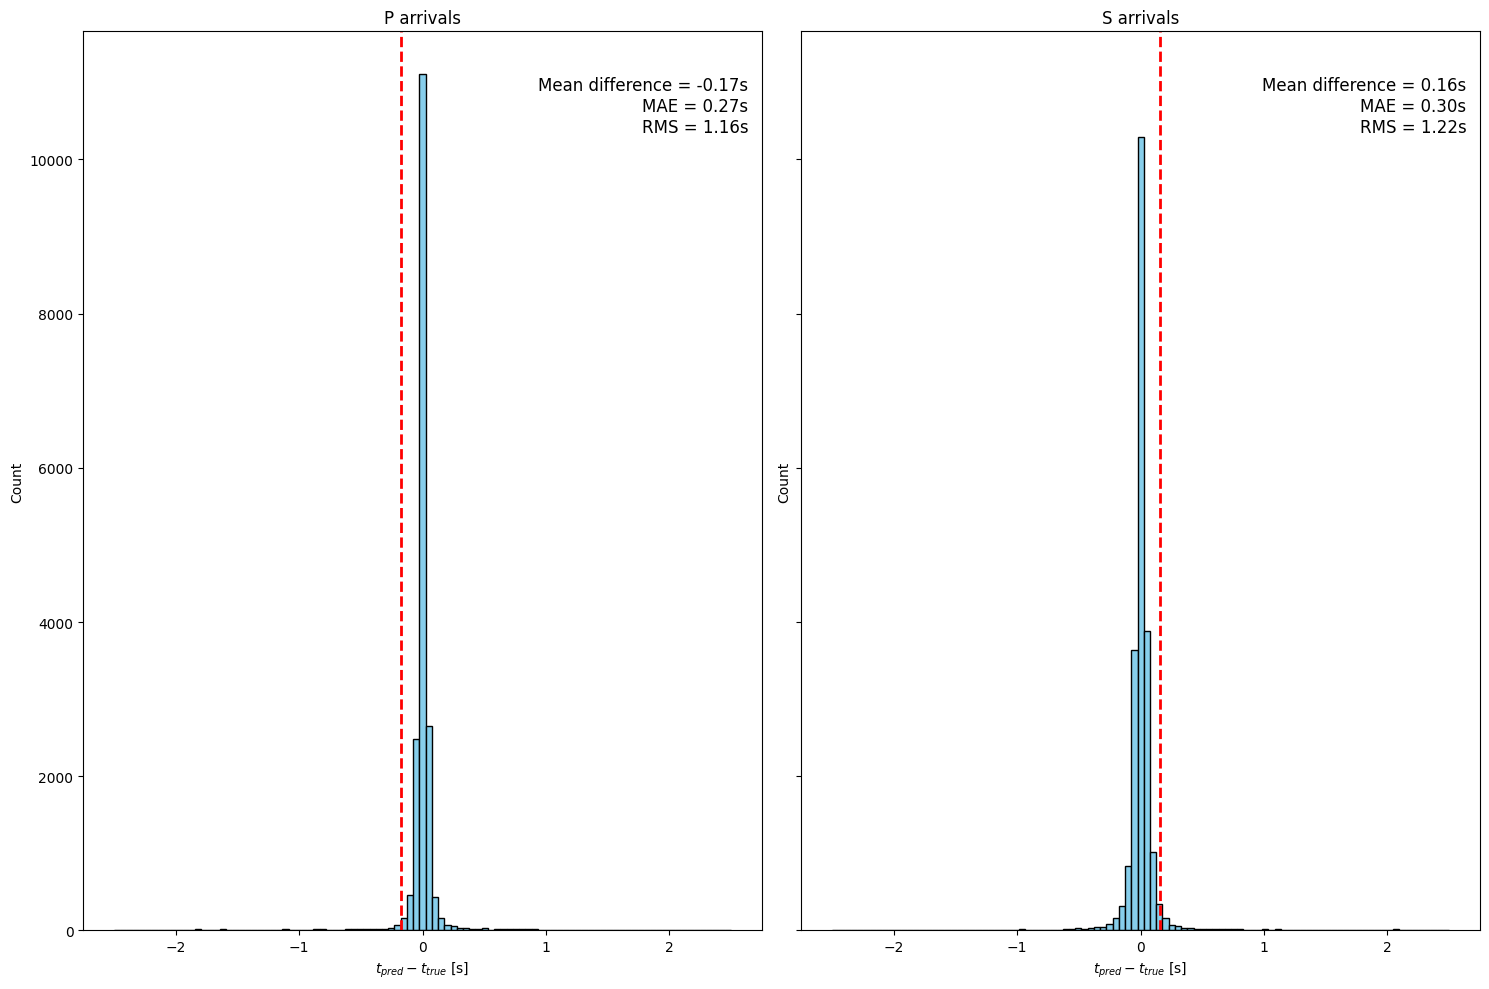

: 

In [ ]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(1, 2, sharey=True)

for i, phase in enumerate(["P", "S"]):
    ax = axs[i]
    ax.set_title(f"{phase} arrivals")

    pred_phase = results[results["phase_label"] == phase]
    pred_col = f"{phase.lower()}_sample_pred"

    # Time difference in seconds
    diff = (pred_phase[pred_col] - pred_phase["phase_onset"]) / pred_phase[
        "sampling_rate"
    ]


    # Compute stats
    mean_offset = diff.mean()
    mae = np.mean(np.abs(diff))
    rms = np.sqrt(np.mean(diff**2))

    # Plot histogram
    bins = np.linspace(-2.5, 2.5, 100)
    ax.hist(diff, bins=bins, color="skyblue", edgecolor="k")
    ax.axvline(
        mean_offset,
        color="r",
        linestyle="--",
        linewidth=2,
        label=f"Mean offset = {mean_offset:.2f}s",
    )

    # Axis labels and annotation
    ax.set_xlabel("$t_{pred} - t_{true}$ [s]")
    ax.set_ylabel("Count")
    ax.text(
        0.98,
        0.95,
        f"Mean difference = {mean_offset:.2f}s\n"
        f"MAE = {mae:.2f}s\n"
        f"RMS = {rms:.2f}s\n",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=12,
        color="k",
    )

plt.tight_layout()
plt.show()

In [ ]:
test_generator = sbg.GenericGenerator(dataset.test())
test_generator.add_augmentations(model.get_augmentations())

Detection probability: 0.7910792231559753
P or S: 0.9908639788627625


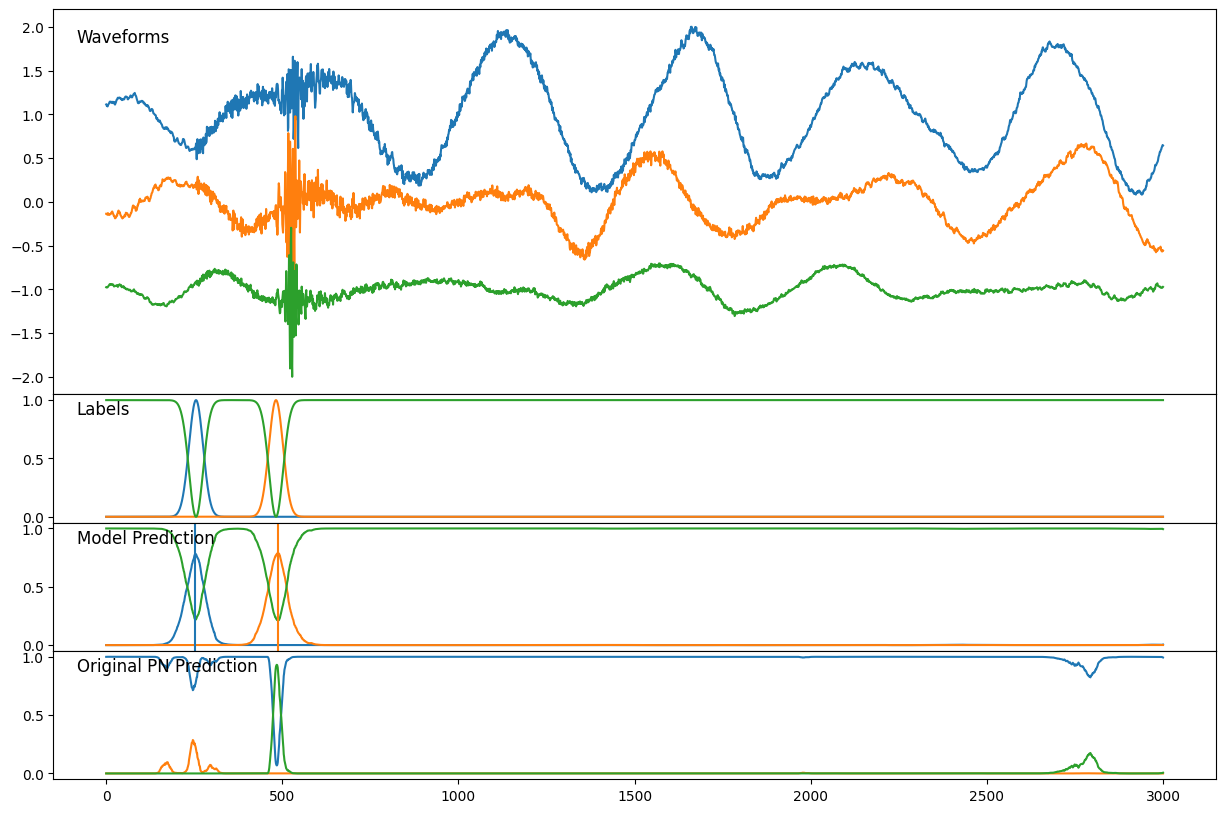

In [ ]:
import random
from seisbench.models.phasenet import PhaseNet


pn = PhaseNet.from_pretrained("original")


random.seed(42)
idx = np.random.randint(len(test_generator))
sample = test_generator[idx]

x = sample["X"]
y = sample["y"]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(
    4, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": (3, 1, 1, 1)}
)


pred_original = pn(torch.tensor(x.reshape(1, 3, 3001)))
pred_original = pred_original.detach().numpy()[0]


with torch.no_grad():
    pred = model(torch.tensor(x.reshape(1, 3, 3001)))
    pred = pred.cpu().numpy()[0]

ax_waveforms, ax_label, ax_pred, ax_pred_original = axs

ax_waveforms.plot(x.T + np.array([1.0, 0.0, -1.0]))
ax_label.plot(y.T)
ax_pred.plot(pred.T)
ax_pred_original.plot(pred_original.T)

batch = {key: torch.tensor(val).unsqueeze(0) for key, val in sample.items()}
batch["window_borders"] = torch.tensor([[0, 3000]])

score_detection, score_p_or_s, p_sample, s_sample = model.predict_step(batch)
ax_pred.axvline(p_sample[0], color="C0")
ax_pred.axvline(s_sample[0], color="C1")

for ax, label in zip(axs, ("Waveforms", "Labels", "Model Prediction", "Original PN Prediction")):
    ax.text(0.02, 0.95, label, transform=ax.transAxes, ha="left", va="top", fontsize=12)

print("Detection probability:", score_detection[0].item())
print("P or S:", score_p_or_s[0].item())

In [ ]:
waveform_data = torch.load("notebooks/example_waveform.pt", map_location=torch.device("cpu"))


predictions = model(waveform_data)
torch.save(predictions, "notebooks/example_predictions_100_epochs.pt")

: 